In [1]:
import torch
import pytorch_lightning as pl

%matplotlib inline
import matplotlib.pyplot as plt

print(torch.__version__)

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)

from hydra.experimental import initialize, compose

from bliss import sleep
from bliss.datasets import simulated

import numpy as np

torch.manual_seed(84)
np.random.seed(43)

1.7.0


In [2]:
import sys
sys.path.insert(0, './m2_utils/')

import plotting
import m2_data
import summary_statistics

In [3]:
%env BLISS_HOME=/home/runingli/astronomy/celeste/

env: BLISS_HOME=/home/runingli/astronomy/celeste/


# Get config file

In [4]:
overrides = dict(
    model="m2",
    dataset="m2",
    training="m2",
)

overrides = [f"{key}={value}" for key, value in overrides.items()]

In [5]:
with initialize(config_path="../../config"):
    cfg = compose("config", overrides=overrides)

In [6]:
cfg.model.decoder.params.update({'ptile_padding': 6, 
                                 'max_sources': 5})

cfg.model.encoder.params.update({'max_detections': 2})

# Load dataset and encoder

In [7]:
dataset = simulated.SimulatedDataset(cfg)
sleep_net = sleep.SleepPhase(cfg, dataset)
trainer = pl.Trainer(**cfg.training.trainer)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


# Plot an example image

In [8]:
batch = dataset.get_batch()

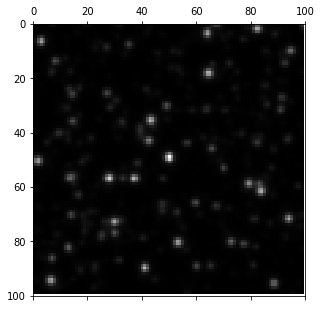

In [9]:
%matplotlib inline

slen = batch['images'].shape[-1]

image_indx = 0

image = batch['images'][image_indx, 0].cpu()

f, axarr = plt.subplots(1, 1, figsize=(5, 5))
plotting.plot_image(axarr, image)

# Plot some subimages

In [10]:
# get locations on the full image
_, locs_full = sleep_net.image_encoder.get_full_params_from_sampled_params(slen, 
                                                            batch['n_sources'][0:1], 
                                                            batch['locs'][0:1])

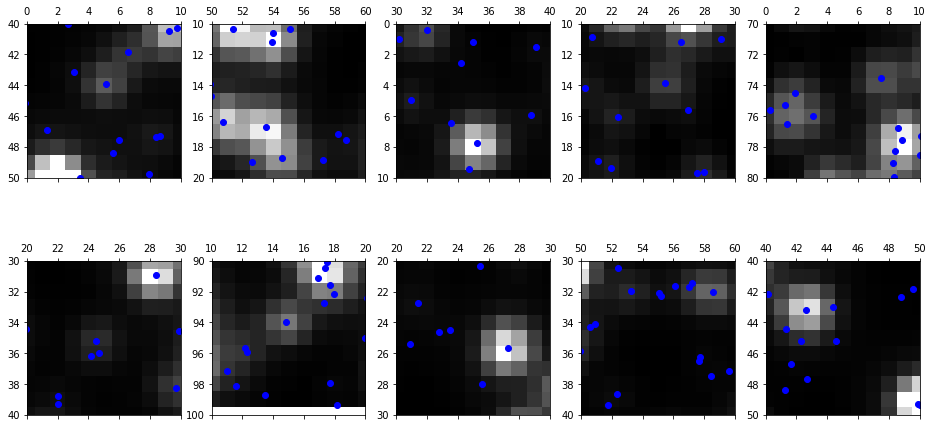

In [11]:
f, axarr = plt.subplots(2, 5, figsize=(16, 8))

subimage_slen = 10
indx_vec = np.arange(0, slen, subimage_slen)

for i in range(10): 
    x0 = np.random.choice(indx_vec)
    x1 = np.random.choice(indx_vec)
    
    ax = axarr[i // 5,  i % 5]
    
    plotting.plot_locations(locs_full.squeeze(), slen, ax, marker = 'o', color = 'b')
    
    plotting.plot_image(ax, image, 
               x0, x1, subimage_slen, subimage_slen)


# Train!

In [12]:
# trainer.fit(sleep_net)
# torch.save(sleep_net.image_encoder.state_dict(), './starnet')

sleep_net.image_encoder.load_state_dict(torch.load('./starnet')); 

In [13]:
sleep_net.image_encoder.to(device);
sleep_net.image_encoder.eval();

# Plot results on simulated data

In [14]:
image_indx = 0

image = batch['images'][image_indx]
true_tile_n_stars = batch['n_stars'][image_indx]
true_tile_locs = batch['locs'][image_indx]
true_tile_fluxes = batch['fluxes'][image_indx]


# get locations on the full image (for plotting)
_, true_full_locs, true_full_fluxes =\
    sleep_net.image_encoder.get_full_params_from_sampled_params(slen, 
                                                            true_tile_n_stars.unsqueeze(0), 
                                                            true_tile_locs.unsqueeze(0), 
                                                            true_tile_fluxes.unsqueeze(0))

nelec_per_nmgy = 856.

In [15]:
# get map estiamates
map_nstars, map_locs, _, map_fluxes, _ = sleep_net.image_encoder.map_estimate(image.unsqueeze(0))

map_nstars = map_nstars.detach()
map_locs = map_locs.detach()
map_fluxes = map_fluxes.detach()

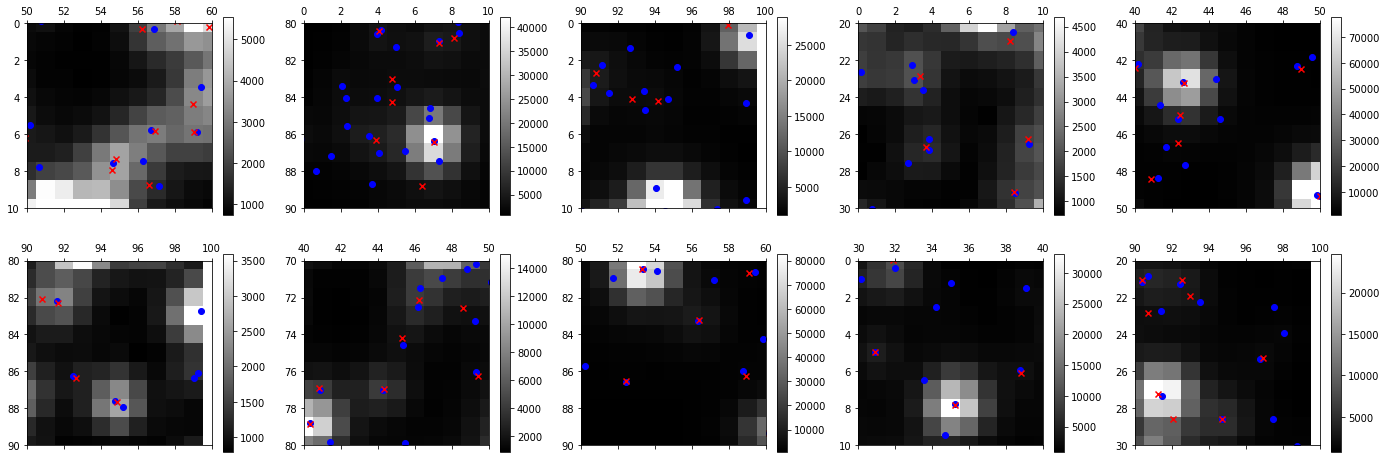

In [16]:
f, axarr = plt.subplots(2, 5, figsize=(24, 8))

subimage_slen = 10
indx_vec = np.arange(0, slen, subimage_slen)

for i in range(10): 
    x0 = np.random.choice(indx_vec)
    x1 = np.random.choice(indx_vec)
    
    ax = axarr[i // 5,  i % 5]
    
    plotting.plot_locations(true_full_locs.squeeze(), slen, ax, marker = 'o', color = 'b')
    plotting.plot_locations(map_locs.squeeze(), slen, ax, marker = 'x', color = 'red')
    
    im = plotting.plot_image(ax, image[0], 
               x0, x1, subimage_slen, subimage_slen)
    
    f.colorbar(im, ax = ax)

In [17]:
summary_statistics.get_summary_stats(map_locs.squeeze().cpu(), 
                            true_full_locs[0].cpu(), 
                            slen, 
                            map_fluxes.exp()[0, :, 0].cpu(), 
                            true_full_fluxes[0, :, 0].cpu(),
                            nelec_per_nmgy)[0:2]

(tensor(0.3692), tensor(0.5383))

(array([ 14., 122., 204., 133., 101.,  61.,  51.,  21.,  26.,  10.]),
 array([2.7765305, 3.109163 , 3.4417953, 3.774428 , 4.1070604, 4.439693 ,
        4.7723255, 5.1049576, 5.43759  , 5.7702227, 6.102855 ],
       dtype=float32),
 <a list of 10 Patch objects>)

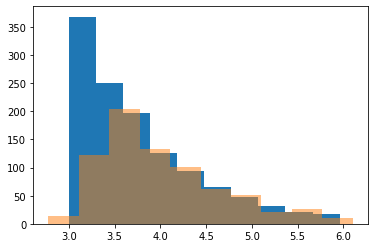

In [18]:
# flux distributions
plt.hist(torch.log10(true_full_fluxes[0, :, 0].cpu()))
plt.hist(torch.log10(map_fluxes.exp()[0, :, 0].cpu()), alpha = 0.5)

# plot results on SDSS data

In [19]:
sdss_image, _, hubble_locs, hubble_fluxes, sdss_data, _ = \
    m2_data.load_m2_data(sdss_dir = '../../data/sdss/',
                        hubble_dir = '../../data/hubble/')

nelec_per_nmgy = sdss_data[0]['nelec_per_nmgy'][0].mean()

loading sdss image from ../../data/sdss/2583/2/136/frame-r-002583-2-0136.fits
loading sdss image from ../../data/sdss/2583/2/136/frame-i-002583-2-0136.fits
loading hubble data from  ../../data/hubble/hlsp_acsggct_hst_acs-wfc_ngc7089_r.rdviq.cal.adj.zpt
getting sdss coordinates from:  ../../data/sdss/2583/2/136/frame-r-002583-2-0136.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]



 aligning images. 
 Getting sdss coordinates from:  ../../data/sdss/2583/2/136/frame-i-002583-2-0136.fits

 returning image at x0 = 630, x1 = 310


In [26]:
use_simulated_data = False

In [27]:
if use_simulated_data: 
    
    
    # convert to tile parameterization
    tile_coords = plotting._get_tile_coords(slen = 100, 
                                 tile_slen = 2)

    hubble_tile_locs, hubble_tile_fluxes, hubble_tile_nstars, _  = \
        plotting.get_params_in_tiles(tile_coords, 
                                        hubble_locs.unsqueeze(0), 
                                        hubble_fluxes.unsqueeze(0), 
                                        slen = 100,
                                        subimage_slen=2)
    max_stars = int(hubble_tile_nstars.max())
        
    # reshape 
    n_tiles = tile_coords.shape[0]
    _n_sources = hubble_tile_nstars.unsqueeze(0)
    _locs = hubble_tile_locs.unsqueeze(0)
    _galaxy_bool = torch.zeros(1, n_tiles, max_stars, 1, device = device)
    _galaxy_params = torch.zeros(1, n_tiles, max_stars, 8, device = device)
    _fluxes = hubble_tile_fluxes.unsqueeze(0)

    # simulate image
    image = dataset.image_decoder.render_images(
                                _n_sources,
                                _locs,
                                _galaxy_bool,
                                _galaxy_params,
                                _fluxes).detach()
else: 
    image = sdss_image.unsqueeze(0)

In [28]:
# get map estiamates
map_nstars, map_locs, _, map_fluxes, _ = sleep_net.image_encoder.map_estimate(image)

map_nstars = map_nstars.detach()
map_locs = map_locs.detach()
map_fluxes = map_fluxes.detach()

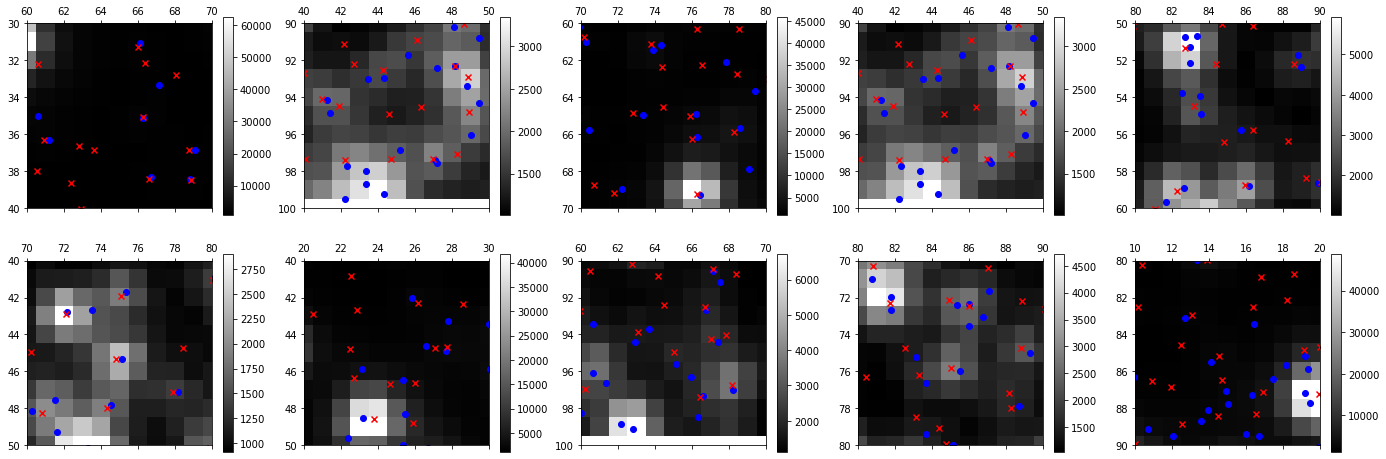

In [32]:
f, axarr = plt.subplots(2, 5, figsize=(24, 8))

subimage_slen = 10
indx_vec = np.arange(0, slen, subimage_slen)

for i in range(10): 
    x0 = np.random.choice(indx_vec)
    x1 = np.random.choice(indx_vec)
    
    ax = axarr[i // 5,  i % 5]
    
    plotting.plot_locations(hubble_locs, slen, ax, marker = 'o', color = 'b')
    plotting.plot_locations(map_locs.squeeze(), slen, ax, marker = 'x', color = 'red')
    
    im = plotting.plot_image(ax, image[0, 0], 
               x0, x1, subimage_slen, subimage_slen)
    
    f.colorbar(im, ax = ax)

In [30]:
summary_statistics.get_summary_stats(map_locs.squeeze().cpu(), 
                            hubble_locs.cpu(), 
                            slen, 
                            map_fluxes.exp()[0, :, 0].cpu(), 
                            hubble_fluxes[:, 0].cpu(),
                            nelec_per_nmgy)[0:2]

(tensor(0.3566), tensor(0.2800))

(array([277., 443., 311., 169.,  51.,  16.,   8.,   5.,   4.,   1.]),
 array([2.8986   , 3.2191803, 3.5397608, 3.860341 , 4.1809216, 4.501502 ,
        4.822082 , 5.1426625, 5.463243 , 5.783823 , 6.1044035],
       dtype=float32),
 <a list of 10 Patch objects>)

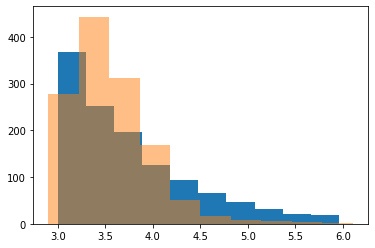

In [31]:
# flux distributions
plt.hist(torch.log10(true_full_fluxes[0, :, 0].cpu()))
plt.hist(torch.log10(map_fluxes.exp()[0, :, 0].cpu()), alpha = 0.5)